# Binary Phase Field Benchmark

FiPy implementation of phase transormation in 2D with solutal driving force

**Do not edit `binary_phase_field.py`**. Generate the batch-runnable file from the notebook with
```bash
jupyter nbconvert binary_phase_field.ipynb --to python --output-dir=../scripts/
```

## Import Python modules

In [1]:
import argparse
import json
import os
import re
import sys

import fipy as fp
from fipy.tools import numerix as nmx
from fipy.tools import parallelComm

Jupyter notebook handles some things differently than from the commandline

In [2]:
try:
    from IPython import get_ipython
    isnotebook = get_ipython() is not None
except:
    isnotebook = False

## Initialize
### Load parameters

In [3]:
parser = argparse.ArgumentParser()
parser.add_argument("--output", help="directory to store results in",
                    default=None)
parser.add_argument("--store_by_solver",
                    help="store results in nested subdirectories based on solver,"
                    "preconditioner, and system size",
                    action='store_true')
parser.add_argument("--restart", help="solution to initialize from",
                    default=None)
parser.add_argument("--checkpoint_interval", help="frequency to save results",
                    type=float, default=6.)
parser.add_argument("--totaltime", help="duration of full simulation",
                    type=float, default=600.)
parser.add_argument("--numnuclei", help="number of nuclei",
                    type=int, default=100)
parser.add_argument("--factor", help="fraction of critical nucleus size for new nuclei",
                    type=float, default=1.1)
parser.add_argument("--nucleation_scale", help="size of domain for nuclei",
                    type=float, default=1000)
parser.add_argument("--numberOfElements", help="number of total cells in a Grid2D",
                    type=int, default=1000000)
parser.add_argument("--solver", help="solver class to use",
                    choices=("pcg", "cgs", "gmres", "lu"), default="pcg")
parser.add_argument("--preconditioner", help="preconditioner class to use",
                    choices=("jacobi", "ilu", "ssor", "icc", "none"), default="none")
parser.add_argument("--sweeps", help="number of nonlinear sweeps to take",
                    type=int, default=5)
parser.add_argument("--iterations", help="maximum number of linear iterations to take for each sweep",
                    type=int, default=1000)
parser.add_argument("--tolerance", help="linear solver tolerance",
                    type=float, default=1e-10)
parser.add_argument("--store_matrix",
                    help="store the matrix and RHS vector along with other output",
                    action='store_true')

_StoreTrueAction(option_strings=['--store_matrix'], dest='store_matrix', nargs=0, const=True, default=False, type=None, choices=None, required=False, help='store the matrix and RHS vector along with other output', metavar=None)

### Set any parameters for interactive notebook

In [14]:
if isnotebook:
    # argv = ["--numberOfElements=10000", "--totaltime=1.2", "--checkpoint_interval=0.12",
    #         "--nucleation_scale=100", "--output=nucleation6"]
    argv = ["--numberOfElements=1000000", "--nucleation_scale=1000", "--output=solidification2",
           "--restart=../../results/nucleation/nucleation18/t=300.0.npz",
           "--store_matrix"]
else:
    argv = None

In [15]:
args, unknowns = parser.parse_known_args(args=argv)

### Initialize mesh and solution variables

Either restart from some `path/to/restart/t={time}.npz`, where the time is assigned to `elapsed`

or

Create a mesh based on parameters. Set
>  the computational domain is ... 1000×1000 

In [16]:
nx = ny = int(nmx.sqrt(args.numberOfElements))
mesh = fp.Grid2D(nx=nx, ny=ny)
phi = fp.CellVariable(mesh=mesh, name="$\phi$", value=0., hasOld=True)
elapsed = 0.

In [17]:
if args.restart is not None:
    data = nmx.load(args.restart)
    lower, upper = int((1000 - nx) / 2), int((1000 + nx) / 2)
    phi.setValue(data["phi"][lower:upper, lower:upper].flat)

    # scanf("%g") simulator
    # https://docs.python.org/3/library/re.html#simulating-scanf
    scanf_g = "[-+]?(\d+(\.\d*)?|\.\d+)([eE][-+]?\d+)?"
    pattern = ".*t=({g})\.npz".format(g=scanf_g)
    elapsed = float(re.match(pattern, args.restart).group(1))

In [18]:
x, y = mesh.cellCenters[0], mesh.cellCenters[1]
X, Y = mesh.faceCenters[0], mesh.faceCenters[1]

In [19]:
C = fp.CellVariable(mesh=mesh, name="$C$", value=0.7 - 0.4 * phi, hasOld=True)

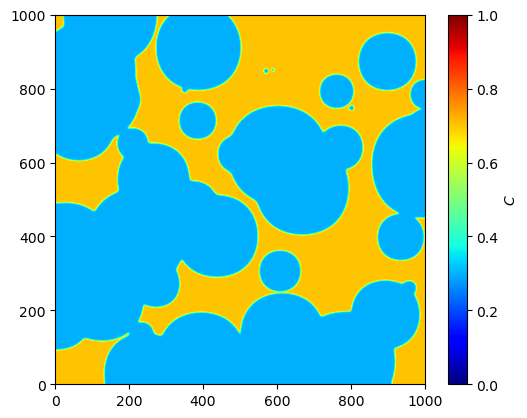

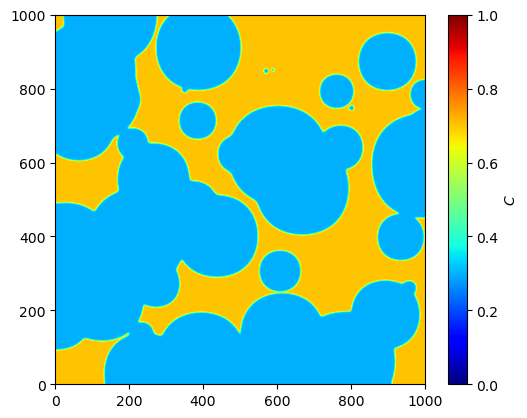

In [20]:
if isnotebook:
    viewer = fp.Viewer(vars=C, datamin=0., datamax=1.)
    viewer.plot()

## Create solver

In [21]:
precon = None

if args.preconditioner == "jacobi":
    precon = fp.JacobiPreconditioner()
elif args.preconditioner == "ilu":
    precon = fp.ILUPreconditioner()
elif args.preconditioner == "ssor":
    precon = fp.SSORPreconditioner()
elif args.preconditioner == "icc":
    precon = fp.ICPreconditioner()
elif args.preconditioner == "none":
    precon = None

if args.solver == "cgs":
    solver_class = fp.LinearCGSSolver
elif args.solver == "gmres":
    solver_class = fp.LinearGMRESSolver
elif args.solver == "lu":
    if args.preconditioner != "none":
        # preconditioned lu doesn't make any sense
        exit()

    solver_class = fp.LinearLUSolver
elif args.solver == "pcg":
    solver_class = fp.LinearPCGSolver

solver = solver_class(tolerance=args.tolerance, criterion="initial",
                      iterations=args.iterations, precon=precon)

## Define governing equation

## Binary Alloy Phase Field

binary diffusion with frozen phase; diffusion with convection due to phase boundary

\begin{align}
\frac{1}{M_\phi}\frac{\partial \phi}{\partial t} &= \nabla\cdot\left(\kappa_\phi\nabla \phi\right)
- \left[
    \left(1-C\right)\frac{L_A\left(T - T_m^A\right)}{T_m^A}
    + C\frac{L_B\left(T - T_m^B\right)}{T_m^B}
\right] p'(\phi)
- \left[
    \left(1-C\right)\frac{W_A}{2}
    + C\frac{W_B}{2}
\right] g'(\phi)
\\
\frac{\partial C}{\partial t} &= \nabla\cdot\left(D_C\nabla C\right)
\\ &\quad {} + \nabla\cdot\left(
    D_C\frac{C\left(1-C\right)V_m}{RT}
    \left\{
        \left[
            \frac{L_B\left(T - T_m^B\right)}{T_m^B}
            - \frac{L_A\left(T - T_m^A\right)}{T_m^A}
        \right] p'(\phi)
        - \frac{W_B - W_A}{2} g'(\phi)
    \right\}
    \nabla \phi\right)
\end{align}

non-dimensionalize

\begin{align}
\frac{1}{M_\phi}\frac{\partial \phi}{\partial t \tau} &= \frac{1}{\lambda}\nabla\cdot\left(\kappa_\phi\frac{1}{\lambda}\nabla \phi\right)
- \left[
    \left(1-C\right)L_A\left(\frac{T}{T_m^A} - 1\right)
    + C L_B\left(\frac{T}{T_m^B} - 1\right)
\right] p'(\phi)
- \left[
    \left(1-C\right)\frac{W_A}{2}
    + C\frac{W_B}{2}
\right] g'(\phi)
\\
\frac{\partial C}{\partial t \tau} &= \frac{1}{\lambda}\nabla\cdot\left(D_C\frac{1}{\lambda}\nabla C\right)
\\ &\quad {} + \frac{1}{\lambda} \nabla\cdot\left(
    D_C\frac{C\left(1-C\right)V_m}{RT}
    \left\{
        \left[
            L_B\left(\frac{T}{T_m^B} - 1\right)
            - L_A\left(\frac{T}{T_m^A} - 1\right)
        \right] p'(\phi)
        - \frac{W_B - W_A}{2} g'(\phi)
    \right\}
    \frac{1}{\lambda} \nabla \phi\right)
\end{align}

\begin{align}
\frac{\partial \phi}{\partial t} &= \nabla\cdot\left(\frac{M_\phi\tau\kappa_\phi}{\lambda^2}\nabla \phi\right)
- \left[
    \left(1-C\right)M_\phi\tau L_A\left(\frac{T}{T_m^A} - 1\right)
    + C M_\phi\tau L_B\left(\frac{T}{T_m^B} - 1\right)
\right] p'(\phi)
- \left[
    \left(1-C\right)\frac{M_\phi\tau W_A}{2}
    + C\frac{M_\phi\tau W_B}{2}
\right] g'(\phi)
\\
\frac{\partial C}{\partial t} &= \nabla\cdot\left(\frac{D_C\tau}{\lambda^2}\nabla C\right)
\\ &\quad {} + \nabla\cdot\left(
    \frac{D_C\tau}{\lambda^2}C\left(1-C\right)
    \left\{
        \left[
            \frac{L_B V_m}{RT}\left(\frac{T}{T_m^B} - 1\right)
            - \frac{L_A V_m}{RT}\left(\frac{T}{T_m^A} - 1\right)
        \right] p'(\phi)
        - \frac{\frac{W_B V_m}{RT} - \frac{W_A V_m}{RT}}{2} g'(\phi)
    \right\}
    \nabla \phi\right)
\end{align}

\begin{align}
M_\phi &= \frac{T_m^A \beta_A}{6 L_A \delta_A}
\\
&\sim \mathrm{\frac{K \frac{cm}{K s}}{\frac{J}{cm^3} cm}}
\\
&\sim \mathrm{\frac{cm^3}{J\,s}}
\end{align}

let
\begin{align}
\tau \equiv \frac{\lambda^2}{M_\phi\kappa_\phi} &\sim \mathrm{cm^2 \frac{J\,s}{cm^3}\frac{cm}{J}}
\\
&\sim \mathrm{s}
\end{align}

\begin{align}
\tilde{L}_? \equiv \tau M_\phi L_? &\sim \mathrm{s\frac{cm^3}{J\,s}\frac{J}{cm^3}}
\\
&\sim 1
\end{align}

\begin{align}
\tilde{W}_? \equiv \tau M_\phi W_? &\sim \mathrm{s\frac{cm^3}{J\,}\frac{J}{cm^3}}
\\
&\sim 1
\end{align}

\begin{align}
\tilde{D}_C \equiv \frac{D_C \tau}{\lambda^2} &= \frac{D_C \lambda^2}{M_\phi\kappa_\phi\lambda^2}
\\
&\sim \mathrm{\frac{cm^2}{s}\frac{J\,s}{cm^3}\frac{cm}{J}}
\\
&\sim 1
\end{align}

\begin{align}
\xi \equiv \frac{V_m}{R T} \frac{1}{\tau M_\phi}
&= \frac{V_m}{R T} \frac{M_\phi \kappa_\phi}{\lambda^2 M_\phi}
\\
&\sim \mathrm{\frac{cm^3}{mol}\frac{mol\,K}{J\,K}\frac{J}{cm^3}}
\\
&\sim 1
\end{align}

\begin{align}
\frac{\partial \phi}{\partial t} &= \nabla^2 \phi
- \left[
    \left(1-C\right)\tilde{L}_A\left(\frac{T}{T_m^A} - 1\right)
    + C \tilde{L}_B\left(\frac{T}{T_m^B} - 1\right)
\right] p'(\phi)
- \left[
    \left(1-C\right)\frac{\tilde{W}_A}{2}
    + C\frac{\tilde{W}_B}{2}
\right] g'(\phi)
\\
\frac{\partial C}{\partial t} &= \nabla\cdot\left(\tilde{D}_C\nabla C\right)
\\ &\quad {} + \nabla\cdot\left(
    \tilde{D}_C C\left(1-C\right)
    \xi
    \left\{
        \left[
            \tilde{L}_B\left(\frac{T}{T_m^B} - 1\right)
            - \tilde{L}_A\left(\frac{T}{T_m^A} - 1\right)
        \right] p'(\phi)
        - \frac{\tilde{W}_B - \tilde{W}_A}{2} g'(\phi)
    \right\}
    \nabla \phi\right)
\end{align}

Comparing the phase equation with the [nucleation benchmark](nucleation.ipynb) equation
$$
\begin{aligned}
\frac{\partial\phi}{\partial t} &= \nabla^2 \phi - g'(\phi) + \Delta f p'(\phi)
\\
\Delta f 
&\approx -\left[\left(1-C\right)\tilde{L}_A\left(\frac{T}{T_m^A} - 1\right)
+ C \tilde{L}_B\left(\frac{T}{T_m^B} - 1\right)\right]
\\
&= -\left[\tilde{L}
+ C \Delta \tilde{L}\right]
\\
1 &\approx \left[
    \left(1-C\right)\frac{\tilde{W}_A}{2}
    + C\frac{\tilde{W}_B}{2}
\right]
\\
&= \left[
    \frac{\tilde{W}}{2}
    + C\frac{\Delta\tilde{W}}{2}
\right]
\end{aligned}
$$

To keep parameters centered on the same values used for the nucleation benchmark, we let
\begin{align}
\Delta f &\equiv -\left[
    \tilde{L} + \frac{\Delta\tilde{L}}{2}
\right]
\\
\tilde{L}
&\equiv     
-\Delta f\left(1 + \frac{1}{2}\zeta\right)
\\
\zeta &\equiv \frac{\Delta\tilde{L}}{\Delta f}
\\
\frac{\tilde{W}}{2} &\equiv 1 - \frac{\Delta\tilde{W}}{4}
\end{align}

\begin{align}
\frac{\partial \phi}{\partial t} &= \nabla^2 \phi
+ \Delta f\left[
    1 + \frac{1}{2}\left(1 - 2 C\right)\zeta
\right] p'(\phi)
- \left[
    1 - \frac{1}{4}\left(1 - 2 C\right)\Delta\tilde{W}
\right] g'(\phi)
\\
\frac{\partial C}{\partial t} &= \nabla\cdot\left(\tilde{D}_C\nabla C\right)
\\ &\quad {} + \nabla\cdot\left(
    \tilde{D}_C C\left(1-C\right)
    \xi
    \left\{
        \zeta \Delta f p'(\phi)
        - \frac{\Delta\tilde{W}}{2} g'(\phi)
    \right\}
    \nabla \phi\right)
\end{align}

\begin{align}
\xi &\equiv \frac{V_m}{R T} \frac{1}{\tau M_\phi}
\\
&= \mathrm{\frac{7.42~cm^3}{mol}
\frac{mol\,K}{8.314~J}
\frac{1}{1500~K}
\frac{1}{1500~K}
\frac{K\,s}{0.33~cm}
6
\frac{2000~J}{cm^3}
1.5~5\times 10^{-6}~cm
\frac{1}{\tau}}
\\
&\approx \frac{10^{-7} s}{\tau}
\end{align}

\begin{align}
\xi &\equiv \frac{V_m}{R T} \frac{\kappa_\phi}{\lambda^2}
\\
&= \mathrm{\frac{7.42~cm^3}{mol}
\frac{mol\,K}{8.314~J}
\frac{1}{1500~K}
6 \cdot
3\times 10^{-5} \frac{J}{cm^2}
1.5 \cdot
5\times 10^{-6} cm
\frac{1}{\lambda^2}}
\\
&\approx 
\frac{\mathrm{10^{-12} cm^2}}{\lambda^2}
\end{align}

In [30]:
(7.42 * 6 * 3e-5 * 1.5 * 5e-6)/(8.314 * 1500)

8.032234784700505e-13

\begin{align}
\tilde{D}_C &\equiv \frac{D_C}{M_\phi\kappa_\phi}
\\
&\equiv \frac{D_C L_?}{T_m^? \beta_? \sigma_?}
\\
&= \mathrm{10^{-5}\frac{cm^2}{s}
2000\frac{J}{cm^3}
\frac{1}{1500~K}
\frac{K\,s}{0.33~cm}
\frac{cm^2}{3\times 10^{-5}~J}
}
\\
&\approx 1.3
\end{align}

In [34]:
1 / (1e-5 * 2000 / (1500 * 0.33 * 3e-5))

0.7424999999999999

Let
\begin{align}
\tilde{D}_C \xi &\equiv 1
\\
\xi &\approx \frac{1}{1.3}
\\
\frac{\mathrm{10^{-12}~cm^2}}{\lambda^2} &\approx \frac{1}{1.3}
\\
\lambda &\approx \mathrm{1.16 \times 10^{-6}~cm}
\end{align}

Freeze the phase field and solve the diffusion equation

In [28]:
def p(phi):
    return phi**3 * (6 * phi**2 - 15 * phi + 10)

DeltaDelta_f = 0.2 / (6 * nmx.sqrt(2.))
xi = 100
phaseTransformationVelocity = xi * (1 - C).harmonicFaceValue * DeltaDelta_f * p(phi).faceGrad

eq = (fp.TransientTerm(var=C)
      == fp.DiffusionTerm(var=C)
      + fp.ConvectionTerm(coeff=phaseTransformationVelocity, var=C))

## Setup output

### Setup ouput storage

In [23]:
if (args.output is not None) and (parallelComm.procID == 0):
    if args.store_by_solver:
        suite = solver.__module__.split('.')[2]
        if args.preconditioner is None:
            preconditioner_name = "none"
        else:
            preconditioner_name = precon.__class__.__name__
        path = os.path.join(args.output, suite,
                            solver.__class__.__name__,
                            preconditioner_name,
                            str(nx * ny))
    else:
        path = args.output

    os.makedirs(path)

if parallelComm.procID == 0:
    print("storing results in {0}".format(path))

storing results in solidification2


### Define output routines

In [24]:
def saveC(elapsed):
    C_value = C.globalValue.reshape((nx, ny))
    if parallelComm.procID == 0:
        fname = os.path.join(path, "t={}.npz".format(elapsed))
        nmx.savez(fname, C=C_value)

def saveMatrix(elapsed):
    mtxname = os.path.join(path, "t={}.mtx".format(elapsed))
    eq.matrix.exportMmf(mtxname)
    
    rhs_value = eq.RHSvector
    if parallelComm.procID == 0:
        rhsname = os.path.join(path, "t={}.rhs.npz".format(elapsed))
        nmx.savez(rhsname, rhs=rhs_value)

def checkpoint_data(elapsed, store_matrix=False):
    saveC(elapsed)
    if store_matrix:
        saveMatrix(elapsed)

### Figure out when to save

In [25]:
checkpoints = (fp.numerix.arange(int(elapsed / args.checkpoint_interval),
                                 int(args.totaltime / args.checkpoint_interval))
               + 1) * args.checkpoint_interval

checkpoints.sort()

## Solve and output

In [26]:
times = checkpoints
times = times[(times > elapsed) & (times <= args.totaltime)]

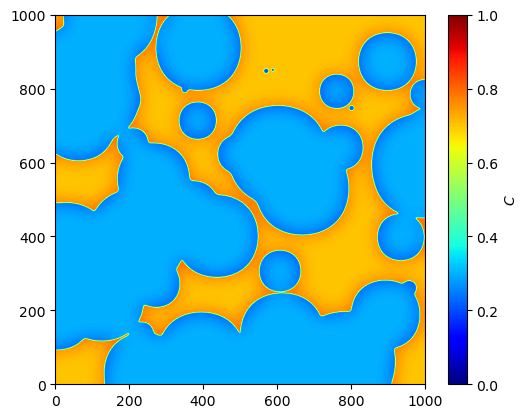

In [27]:
from steppyngstounes import CheckpointStepper, FixedStepper

eq.cacheMatrix()
eq.cacheRHSvector()

C.updateOld()
for checkpoint in CheckpointStepper(start=elapsed,
                                    stops=times,
                                    stop=args.totaltime):

    for step in FixedStepper(start=checkpoint.begin,
                             stop=checkpoint.end,
                             size=100.):

        state = dict(state="START", numberOfElements=mesh.numberOfCells, sweeps=args.sweeps)
        if precon is None:
            state["preconditioner"] = None
        else:
            state["preconditioner"] = precon.__class__.__name__

        solver._log.debug(json.dumps(state))

        for sweep in range(args.sweeps):
            res = eq.sweep(var=C, dt=step.size, solver=solver)

        state["state"] = "END"
        solver._log.debug(json.dumps(state))

        C.updateOld()
        # stats.append(current_stats(step.end))

        _ = step.succeeded(error=res / 1e-3)

    if checkpoint.end in checkpoints:
        # don't save nucleation events?
        checkpoint_data(checkpoint.end, store_matrix=args.store_matrix)

    if isnotebook:
        viewer.plot()
        # labelViewer.plot()

    _ = checkpoint.succeeded()